In [62]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [63]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Thesis pipeline utilities
from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load Gold Data (Submissions + Comments)

**New Approach - Thread-Aware Topic Assignment:**

Instead of assigning topics to individual comments, we now:
1. Assign topics at the **thread level** (using submission as anchor)
2. Filter comments by requiring BOTH:
   - Thread has assigned topic (submission similarity > threshold)
   - Comment itself meets similarity threshold

This respects Reddit's threaded conversation structure.

In [67]:
# Paths
gold_comments_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'comments'
gold_submissions_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'submissions'
output_path = workspace_root / 'data' / '02_topics' / 'reddit'
output_path.mkdir(parents=True, exist_ok=True)

print(f"Comments: {gold_comments_path}")
print(f"Submissions: {gold_submissions_path}")
print(f"Output: {output_path}")

print(f"\nPaths exist:")
print(f"  Comments: {gold_comments_path.exists()}")
print(f"  Submissions: {gold_submissions_path.exists()}")

Comments: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/02_gold/reddit/comments
Submissions: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/02_gold/reddit/submissions
Output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit

Paths exist:
  Comments: True
  Submissions: True


In [68]:
# Load submissions
print("Loading submissions...")

submission_files = list(gold_submissions_path.glob('*.parquet'))
print(f"Found {len(submission_files)} submission files")

submissions_list = []
for file in sorted(submission_files):
    df = read_parquet(file)
    submissions_list.append(df)
    print(f"  {file.name}: {len(df):,} submissions")

df_submissions = pd.concat(submissions_list, ignore_index=True)

print(f"\n✓ Total submissions: {len(df_submissions):,}")
print(f"Columns: {df_submissions.columns.tolist()}")

# Load comments
print("\nLoading comments...")

comment_files = list(gold_comments_path.glob('*.parquet'))
print(f"Found {len(comment_files)} comment files")

comments_list = []
for file in sorted(comment_files):
    df = read_parquet(file)
    comments_list.append(df)
    print(f"  {file.name}: {len(df):,} comments")

df_comments = pd.concat(comments_list, ignore_index=True)

print(f"\n✓ Total comments: {len(df_comments):,}")
print(f"Columns: {df_comments.columns.tolist()}")

print(f"\nData summary:")
print(f"  Submissions: {len(df_submissions):,}")
print(f"  Comments: {len(df_comments):,}")
print(f"  Avg comments per submission: {len(df_comments)/len(df_submissions):.1f}")

Loading submissions...
Found 2 submission files
  2016-09.parquet: 386,214 submissions
  2016-10.parquet: 537,217 submissions

✓ Total submissions: 923,431
Columns: ['submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id', 'subreddit', 'num_comments']

Loading comments...
Found 2 comment files
  2016-09.parquet: 3,766,133 comments
  2016-10.parquet: 4,932,790 comments

✓ Total comments: 8,698,923
Columns: ['comment_id', 'submission_id', 'parent_id', 'created_utc', 'subreddit_id', 'subreddit', 'body']

Data summary:
  Submissions: 923,431
  Comments: 8,698,923
  Avg comments per submission: 9.4


## 2. Define Target Topics

Define 5 political topics with multiple text variations to capture different phrasings and aspects.

In [69]:
# Define topics with multiple query variations
# These will be embedded and averaged to create robust topic representations

topic_definitions = {
    'climate_change': {
        'label': 'Climate Change',
        'description': 'Climate change, global warming, environmental policy, carbon emissions, renewable energy',
        'queries': [
            'climate change and global warming',
            'environmental protection and carbon emissions',
            'renewable energy and fossil fuels',
            'climate science and temperature rise',
            'greenhouse gases and climate policy'
        ]
    },
    'donald_trump': {
        'label': 'Donald Trump',
        'description': 'Donald Trump, his presidency, policies, and actions',
        'queries': [
            'Donald Trump and his presidency',
            'Trump administration policies',
            'President Trump political actions',
            'Trump executive orders and decisions',
            'Donald Trump campaign and election'
        ]
    },
    'gun_control': {
        'label': 'Gun Control',
        'description': 'Gun control, Second Amendment, firearm regulations, mass shootings',
        'queries': [
            'gun control and firearm regulations',
            'Second Amendment rights and gun ownership',
            'mass shootings and gun violence',
            'background checks and gun laws',
            'assault weapons and gun restrictions'
        ]
    },
    'immigration': {
        'label': 'Immigration',
        'description': 'Immigration policy, border control, refugees, DACA, travel ban',
        'queries': [
            'immigration policy and border security',
            'illegal immigration and border wall',
            'refugees and asylum seekers',
            'DACA and dreamers immigration',
            'immigration reform and deportation'
        ]
    },
    'vaccination': {
        'label': 'Vaccination',
        'description': 'Vaccination policy, vaccine mandates, anti-vax movement, public health',
        'queries': [
            'vaccination and vaccine policy',
            'mandatory vaccines and immunization',
            'anti-vaccination movement and vaccine hesitancy',
            'vaccine safety and public health',
            'vaccine mandates and exemptions'
        ]
    }
}

print("Defined topics:")
for topic_id, topic_info in topic_definitions.items():
    print(f"  {topic_id}: {topic_info['label']}")
    print(f"    {topic_info['description']}")
    print(f"    {len(topic_info['queries'])} query variations\n")

Defined topics:
  climate_change: Climate Change
    Climate change, global warming, environmental policy, carbon emissions, renewable energy
    5 query variations

  donald_trump: Donald Trump
    Donald Trump, his presidency, policies, and actions
    5 query variations

  gun_control: Gun Control
    Gun control, Second Amendment, firearm regulations, mass shootings
    5 query variations

  immigration: Immigration
    Immigration policy, border control, refugees, DACA, travel ban
    5 query variations

  vaccination: Vaccination
    Vaccination policy, vaccine mandates, anti-vax movement, public health
    5 query variations



## 3. Load Sentence Embedding Model

Using **all-MiniLM-L6-v2** for efficient semantic similarity:
- Fast inference (~14k sentences/second on CPU)
- Good semantic understanding
- Widely used in research (Reimers & Gurevych, 2019)

In [70]:
# Load pre-trained sentence embedding model
print("Loading sentence embedding model...")
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

print(f"✓ Loaded model: {model_name}")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Max sequence length: {model.max_seq_length}")

Loading sentence embedding model...
✓ Loaded model: sentence-transformers/all-MiniLM-L6-v2
  Embedding dimension: 384
  Max sequence length: 256


## 4. Create Topic Embeddings

Embed all query variations for each topic and average them to create robust topic representations.

In [71]:
# Create topic embeddings by averaging query embeddings
print("Creating topic embeddings...\n")

topic_embeddings = {}

for topic_id, topic_info in topic_definitions.items():
    print(f"Embedding topic: {topic_info['label']}")
    
    # Embed all query variations
    query_embeddings = model.encode(
        topic_info['queries'],
        show_progress_bar=False,
        convert_to_numpy=True
    )
    
    # Average query embeddings to get topic representation
    topic_embedding = query_embeddings.mean(axis=0)
    topic_embeddings[topic_id] = topic_embedding
    
    print(f"  Embedding shape: {topic_embedding.shape}")
    print(f"  L2 norm: {np.linalg.norm(topic_embedding):.3f}\n")

print(f"✓ Created embeddings for {len(topic_embeddings)} topics")

Creating topic embeddings...

Embedding topic: Climate Change
  Embedding shape: (384,)
  L2 norm: 0.757

Embedding topic: Donald Trump
  Embedding shape: (384,)
  L2 norm: 0.808

Embedding topic: Gun Control
  Embedding shape: (384,)
  L2 norm: 0.807

Embedding topic: Immigration
  Embedding shape: (384,)
  L2 norm: 0.782

Embedding topic: Vaccination
  Embedding shape: (384,)
  L2 norm: 0.875

✓ Created embeddings for 5 topics


In [72]:
# Compute pairwise similarities between topics
print("Topic-to-topic similarities:")
print("=" * 60)

topic_ids = list(topic_embeddings.keys())
topic_matrix = np.stack([topic_embeddings[tid] for tid in topic_ids])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(topic_matrix)

# Display as DataFrame
topic_labels = [topic_definitions[tid]['label'] for tid in topic_ids]
sim_df = pd.DataFrame(similarity_matrix, index=topic_labels, columns=topic_labels)

print(sim_df.round(3))
print("\nNote: Topics should have relatively low similarity to each other")
print("      (< 0.5 is good, confirms they are distinct topics)")

Topic-to-topic similarities:
                Climate Change  Donald Trump  Gun Control  Immigration  \
Climate Change           1.000         0.218        0.163        0.147   
Donald Trump             0.218         1.000        0.213        0.376   
Gun Control              0.163         0.213        1.000        0.163   
Immigration              0.147         0.376        0.163        1.000   
Vaccination              0.169         0.207        0.388        0.179   

                Vaccination  
Climate Change        0.169  
Donald Trump          0.207  
Gun Control           0.388  
Immigration           0.179  
Vaccination           1.000  

Note: Topics should have relatively low similarity to each other
      (< 0.5 is good, confirms they are distinct topics)


## 5. Sample Submissions for Thread-Level Analysis

**Thread-Level Assignment Strategy:**

We assign topics at the submission (thread root) level:
1. Sample submissions for exploration
2. Embed submission text (title + selftext)
3. Calculate submission-level topic similarity
4. Assign thread topic if similarity > threshold
5. All comments in thread are candidates, but each must meet similarity threshold too

In [73]:
# Sample submissions for exploration
SAMPLE_SIZE = 50_000

print(f"Sampling {SAMPLE_SIZE:,} submissions for thread-level analysis...")

if len(df_submissions) > SAMPLE_SIZE:
    df_sub_sample = df_submissions.sample(n=SAMPLE_SIZE, random_state=42).copy()
    print(f"  Sampled {len(df_sub_sample):,} submissions ({len(df_sub_sample)/len(df_submissions)*100:.1f}% of corpus)")
else:
    df_sub_sample = df_submissions.copy()
    print(f"  Using all submissions ({len(df_sub_sample):,})")

# Get comments for these submissions
print(f"\nFiltering comments to sampled submissions...")
sampled_submission_ids = set(df_sub_sample['submission_id'])
df_comm_sample = df_comments[df_comments['submission_id'].isin(sampled_submission_ids)].copy()

print(f"\nSample statistics:")
print(f"  Submissions: {len(df_sub_sample):,}")
print(f"  Comments: {len(df_comm_sample):,}")
print(f"  Avg comments/submission: {len(df_comm_sample)/len(df_sub_sample):.1f}")

Sampling 50,000 submissions for thread-level analysis...
  Sampled 50,000 submissions (5.4% of corpus)

Filtering comments to sampled submissions...

Sample statistics:
  Submissions: 50,000
  Comments: 483,061
  Avg comments/submission: 9.7


In [74]:
# Embed submissions (thread-level context)
print("Embedding submissions for thread-level topic assignment...")
print("This will take a few minutes...\n")

# Combine title and selftext (submission content defines thread topic)
submission_texts = (
    df_sub_sample['title'].fillna('') + ' ' + 
    df_sub_sample['selftext'].fillna('')
).tolist()

# Embed with progress bar
submission_embeddings = model.encode(
    submission_texts,
    batch_size=256,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\n✓ Created submission embeddings: {submission_embeddings.shape}")
print(f"  These represent thread-level topic context")

Embedding submissions for thread-level topic assignment...
This will take a few minutes...



Batches:   0%|          | 0/196 [00:00<?, ?it/s]


✓ Created submission embeddings: (50000, 384)
  These represent thread-level topic context


In [75]:
# Compute submission-level similarity scores (thread topics)
print("Computing submission-level similarity scores (thread topic assignment)...\n")

for topic_id, topic_embedding in topic_embeddings.items():
    topic_label = topic_definitions[topic_id]['label']
    
    # Compute cosine similarity between all submissions and this topic
    similarities = cosine_similarity(submission_embeddings, topic_embedding.reshape(1, -1)).flatten()
    
    # Add to submission dataframe
    df_sub_sample[f'sim_{topic_id}'] = similarities
    
    print(f"{topic_label}:")
    print(f"  Mean similarity: {similarities.mean():.3f}")
    print(f"  Median similarity: {np.median(similarities):.3f}")
    print(f"  Max similarity: {similarities.max():.3f}")
    print(f"  > 0.4: {(similarities > 0.4).sum():,} ({(similarities > 0.4).sum()/len(similarities)*100:.1f}%)")
    print(f"  > 0.5: {(similarities > 0.5).sum():,} ({(similarities > 0.5).sum()/len(similarities)*100:.1f}%)")
    print(f"  > 0.6: {(similarities > 0.6).sum():,} ({(similarities > 0.6).sum()/len(similarities)*100:.1f}%)")
    print()

print("Note: These are THREAD-LEVEL assignments (one per submission)")
print("      Comments will inherit thread topic but must also meet individual threshold")

Computing submission-level similarity scores (thread topic assignment)...

Climate Change:
  Mean similarity: 0.060
  Median similarity: 0.056
  Max similarity: 0.736
  > 0.4: 161 (0.3%)
  > 0.5: 66 (0.1%)
  > 0.6: 14 (0.0%)

Donald Trump:
  Mean similarity: 0.221
  Median similarity: 0.218
  Max similarity: 0.696
  > 0.4: 4,225 (8.5%)
  > 0.5: 533 (1.1%)
  > 0.6: 30 (0.1%)

Gun Control:
  Mean similarity: 0.083
  Median similarity: 0.074
  Max similarity: 0.698
  > 0.4: 329 (0.7%)
  > 0.5: 116 (0.2%)
  > 0.6: 35 (0.1%)

Immigration:
  Mean similarity: 0.138
  Median similarity: 0.133
  Max similarity: 0.784
  > 0.4: 548 (1.1%)
  > 0.5: 145 (0.3%)
  > 0.6: 19 (0.0%)

Vaccination:
  Mean similarity: 0.078
  Median similarity: 0.076
  Max similarity: 0.678
  > 0.4: 20 (0.0%)
  > 0.5: 8 (0.0%)
  > 0.6: 2 (0.0%)

Note: These are THREAD-LEVEL assignments (one per submission)
      Comments will inherit thread topic but must also meet individual threshold


## 7. Assign Topics to Submissions (Thread-Level)

Assign each submission to its best-matching topic if above threshold.
This determines which threads are relevant to our topics.

In [78]:
# Find best matching topic for each submission (thread)
THRESHOLD = 0.4  # Based on manual validation - retains 8.5% of corpus with good quality

print(f"Assigning topics to submissions (thread-level, threshold = {THRESHOLD})...\n")

# Get all similarity columns
sim_cols = [f'sim_{topic_id}' for topic_id in topic_definitions.keys()]

# Find max similarity and corresponding topic
df_sub_sample['max_similarity'] = df_sub_sample[sim_cols].max(axis=1)
df_sub_sample['best_topic_idx'] = df_sub_sample[sim_cols].idxmax(axis=1)

# Map back to topic ID
topic_id_list = list(topic_definitions.keys())
df_sub_sample['best_topic'] = df_sub_sample['best_topic_idx'].apply(
    lambda x: topic_id_list[sim_cols.index(x)] if pd.notna(x) else None
)

# Apply threshold filter
df_sub_sample['thread_topic'] = df_sub_sample.apply(
    lambda row: row['best_topic'] if row['max_similarity'] >= THRESHOLD else None,
    axis=1
)

# Statistics
print(f"Thread-level assignment results:")
print(f"  Submissions with topic (>= {THRESHOLD}): {df_sub_sample['thread_topic'].notna().sum():,} ({df_sub_sample['thread_topic'].notna().sum()/len(df_sub_sample)*100:.1f}%)")
print(f"  Submissions without topic (< {THRESHOLD}): {df_sub_sample['thread_topic'].isna().sum():,} ({df_sub_sample['thread_topic'].isna().sum()/len(df_sub_sample)*100:.1f}%)")

print(f"\nThread topic distribution:")
topic_counts = df_sub_sample['thread_topic'].value_counts()
for topic_id, count in topic_counts.items():
    topic_label = topic_definitions[topic_id]['label']
    pct = count / df_sub_sample['thread_topic'].notna().sum() * 100
    print(f"  {topic_label}: {count:,} ({pct:.1f}%)")

print(f"\n✓ Thread topics assigned to {len(df_sub_sample):,} submissions")

Assigning topics to submissions (thread-level, threshold = 0.4)...

Thread-level assignment results:
  Submissions with topic (>= 0.4): 5,222 (10.4%)
  Submissions without topic (< 0.4): 44,778 (89.6%)

Thread topic distribution:
  Donald Trump: 4,175 (80.0%)
  Immigration: 539 (10.3%)
  Gun Control: 328 (6.3%)
  Climate Change: 160 (3.1%)
  Vaccination: 20 (0.4%)

✓ Thread topics assigned to 50,000 submissions


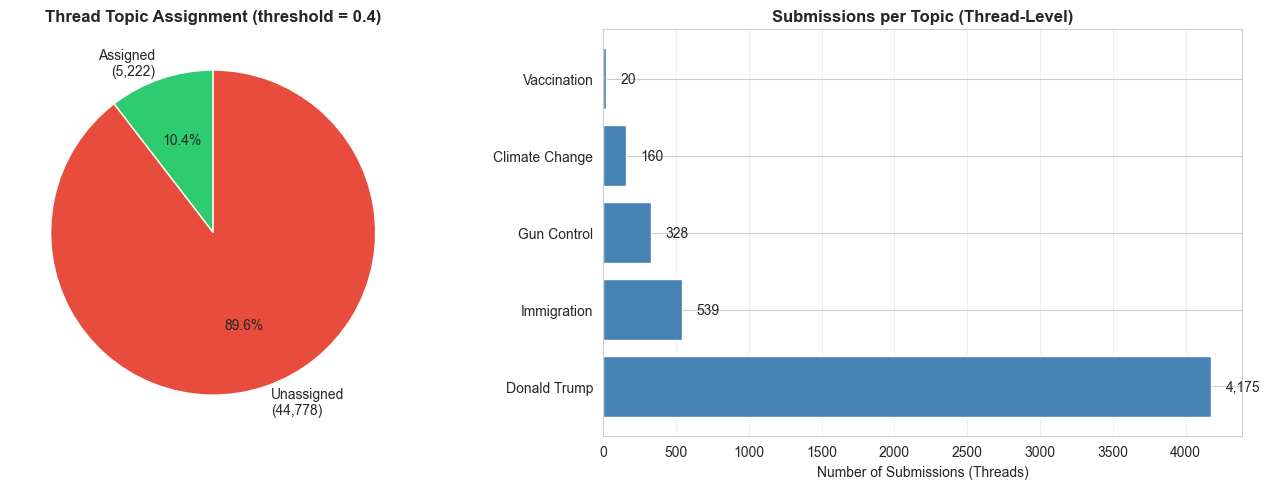

✓ Saved plot: thread_topic_assignment_summary.png


In [79]:
# Visualize thread topic assignments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart: assigned vs unassigned
assigned = df_sub_sample['thread_topic'].notna().sum()
unassigned = df_sub_sample['thread_topic'].isna().sum()

ax1.pie(
    [assigned, unassigned],
    labels=[f'Assigned\n({assigned:,})', f'Unassigned\n({unassigned:,})'],
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    startangle=90
)
ax1.set_title(f'Thread Topic Assignment (threshold = {THRESHOLD})', fontsize=12, fontweight='bold')

# Bar chart: distribution across topics
topic_counts = df_sub_sample['thread_topic'].value_counts()
topic_labels_ordered = [topic_definitions[tid]['label'] for tid in topic_counts.index]

ax2.barh(topic_labels_ordered, topic_counts.values, color='steelblue')
ax2.set_xlabel('Number of Submissions (Threads)')
ax2.set_title('Submissions per Topic (Thread-Level)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add counts on bars
for i, (label, count) in enumerate(zip(topic_labels_ordered, topic_counts.values)):
    ax2.text(count + 100, i, f'{count:,}', va='center')

plt.tight_layout()
plt.savefig(output_path / 'thread_topic_assignment_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: thread_topic_assignment_summary.png")

## 8. Hybrid Approach - Comment-Level Filtering

**Now apply comment-level filtering:**

For comments in topic-assigned threads:
1. Thread must have assigned topic (submission similarity > threshold) ✓
2. Individual comment must also meet similarity threshold
3. Keep comment only if BOTH conditions are met

This hybrid approach respects threading while filtering irrelevant comments.

In [80]:
df_sub_sample.columns

Index(['submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id',
       'subreddit', 'num_comments', 'sim_climate_change', 'sim_donald_trump',
       'sim_gun_control', 'sim_immigration', 'sim_vaccination',
       'max_similarity', 'best_topic_idx', 'best_topic', 'thread_topic'],
      dtype='object')

In [81]:
# Filter to comments in topic-assigned threads only
print("Applying hybrid filtering...\n")

# Step 1: Comments must be in threads with assigned topics
threads_with_topics = set(df_sub_sample[df_sub_sample['thread_topic'].notna()]['submission_id'])
df_comm_filtered = df_comm_sample[df_comm_sample['submission_id'].isin(threads_with_topics)].copy()

print(f"Step 1 - Thread-level filter:")
print(f"  Comments in topic-assigned threads: {len(df_comm_filtered):,} / {len(df_comm_sample):,}")
print(f"  Reduction: {(1 - len(df_comm_filtered)/len(df_comm_sample))*100:.1f}%")

# Step 2: Sample comments for embedding (we'll embed a subset for exploration)
COMMENT_SAMPLE_SIZE = 10_000

print(f"\nSampling {COMMENT_SAMPLE_SIZE:,} comments for similarity analysis...")
if len(df_comm_filtered) > COMMENT_SAMPLE_SIZE:
    df_comm_test = df_comm_filtered.sample(n=COMMENT_SAMPLE_SIZE, random_state=42).copy()
else:
    df_comm_test = df_comm_filtered.copy()

print(f"  Sampled {len(df_comm_test):,} comments")

# Embed comments
print(f"\nEmbedding {len(df_comm_test):,} comments (this may take a minute)...")
comment_texts = df_comm_test['body'].fillna('').tolist()

comment_embeddings = model.encode(
    comment_texts,
    batch_size=256,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\n✓ Comment embeddings created: {comment_embeddings.shape}")

Applying hybrid filtering...

Step 1 - Thread-level filter:
  Comments in topic-assigned threads: 80,633 / 483,061
  Reduction: 83.3%

Sampling 10,000 comments for similarity analysis...
  Sampled 10,000 comments

Embedding 10,000 comments (this may take a minute)...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]


✓ Comment embeddings created: (10000, 384)


In [82]:
# Compute comment-level similarities
print("Computing comment-level similarity scores...\n")

for topic_id, topic_embedding in topic_embeddings.items():
    topic_label = topic_definitions[topic_id]['label']
    
    # Compute cosine similarity for comments
    similarities = cosine_similarity(comment_embeddings, topic_embedding.reshape(1, -1)).flatten()
    
    # Add to dataframe
    df_comm_test[f'sim_{topic_id}'] = similarities
    
    print(f"{topic_label}:")
    print(f"  Mean: {similarities.mean():.3f}, Median: {np.median(similarities):.3f}")
    print(f"  > 0.4: {(similarities > 0.4).sum():,} ({(similarities > 0.4).sum()/len(similarities)*100:.1f}%)")
    print(f"  > 0.5: {(similarities > 0.5).sum():,} ({(similarities > 0.5).sum()/len(similarities)*100:.1f}%)")
    print()

Computing comment-level similarity scores...

Climate Change:
  Mean: 0.055, Median: 0.050
  > 0.4: 51 (0.5%)
  > 0.5: 17 (0.2%)

Donald Trump:
  Mean: 0.203, Median: 0.200
  > 0.4: 423 (4.2%)
  > 0.5: 32 (0.3%)

Gun Control:
  Mean: 0.082, Median: 0.065
  > 0.4: 219 (2.2%)
  > 0.5: 113 (1.1%)

Immigration:
  Mean: 0.111, Median: 0.103
  > 0.4: 119 (1.2%)
  > 0.5: 31 (0.3%)

Vaccination:
  Mean: 0.068, Median: 0.063
  > 0.4: 4 (0.0%)
  > 0.5: 3 (0.0%)



In [84]:
# Apply hybrid filter: comment similarity must match thread topic
print("Applying hybrid filter (Step 2 - Comment-level)...\n")

# Merge thread topics onto comments
df_comm_test = df_comm_test.merge(
    df_sub_sample[['submission_id', 'thread_topic']],
    on='submission_id',
    how='left'
)

# Check if comment similarity for its thread's topic meets threshold
def passes_hybrid_filter(row):
    if pd.isna(row['thread_topic']):
        return False  # No thread topic assigned
    
    topic_sim_col = f"sim_{row['thread_topic']}"
    if topic_sim_col not in row.index:
        return False
    
    return row[topic_sim_col] >= THRESHOLD

df_comm_test['passes_hybrid_filter'] = df_comm_test.apply(passes_hybrid_filter, axis=1)

# Statistics
print(f"Hybrid Filter Results (threshold = {THRESHOLD}):")
print(f"  Comments passing hybrid filter: {df_comm_test['passes_hybrid_filter'].sum():,} / {len(df_comm_test):,}")
print(f"  Pass rate: {df_comm_test['passes_hybrid_filter'].sum()/len(df_comm_test)*100:.1f}%")
print(f"  Fail rate: {(~df_comm_test['passes_hybrid_filter']).sum()/len(df_comm_test)*100:.1f}%")

print(f"\nBreakdown by thread topic:")
for topic_id, topic_info in topic_definitions.items():
    topic_comments = df_comm_test[df_comm_test['thread_topic'] == topic_id]
    if len(topic_comments) > 0:
        pass_rate = topic_comments['passes_hybrid_filter'].sum() / len(topic_comments) * 100
        print(f"  {topic_info['label']}: {pass_rate:.1f}% of comments pass (n={len(topic_comments):,})")


Applying hybrid filter (Step 2 - Comment-level)...

Hybrid Filter Results (threshold = 0.4):
  Comments passing hybrid filter: 693 / 10,000
  Pass rate: 6.9%
  Fail rate: 93.1%

Breakdown by thread topic:
  Climate Change: 24.3% of comments pass (n=173)
  Donald Trump: 4.7% of comments pass (n=8,482)
  Gun Control: 33.8% of comments pass (n=562)
  Immigration: 8.0% of comments pass (n=772)
  Vaccination: 36.4% of comments pass (n=11)


## 9. Visualize Hybrid Approach Results

Compare thread-level vs comment-level filtering.

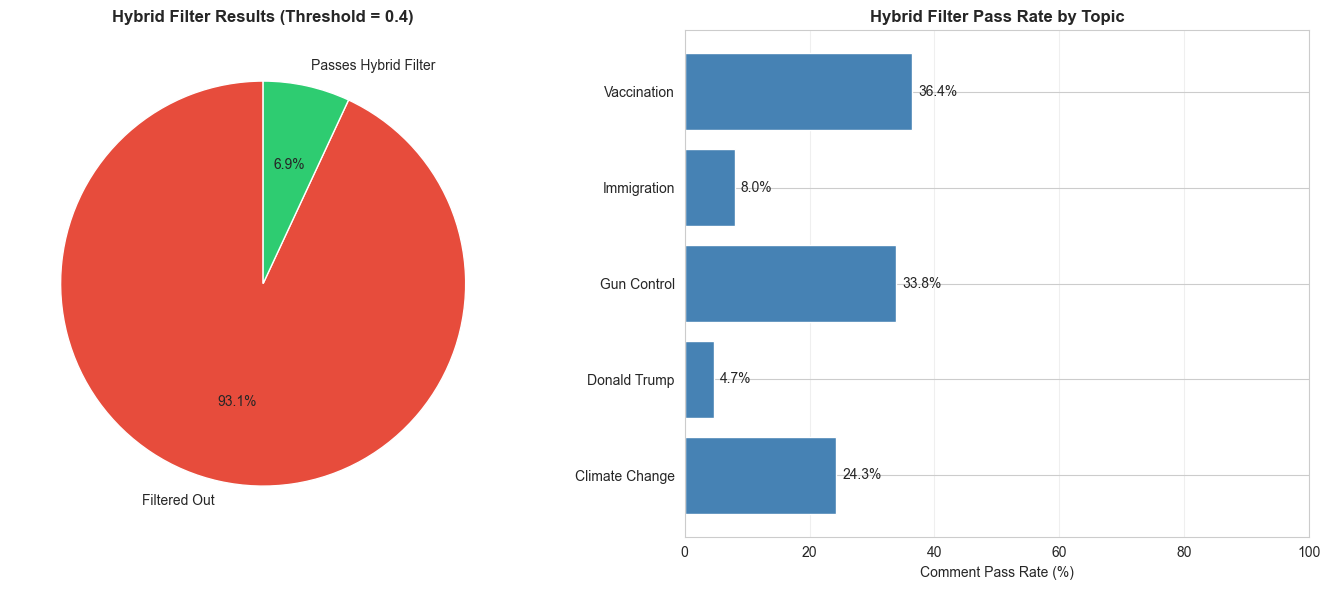

✓ Saved plot: hybrid_filter_results.png


In [85]:
# Visualize hybrid filtering results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Overall pass/fail distribution
ax1 = axes[0]
pass_counts = df_comm_test['passes_hybrid_filter'].value_counts()
colors = ['#e74c3c', '#2ecc71']  # red for fail, green for pass
labels = ['Filtered Out', 'Passes Hybrid Filter']

ax1.pie(
    [pass_counts.get(False, 0), pass_counts.get(True, 0)],
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
ax1.set_title(f'Hybrid Filter Results (Threshold = {THRESHOLD})', fontsize=12, fontweight='bold')

# Plot 2: Pass rate by topic
ax2 = axes[1]
topic_pass_rates = []
topic_labels = []

for topic_id, topic_info in topic_definitions.items():
    topic_comments = df_comm_test[df_comm_test['thread_topic'] == topic_id]
    if len(topic_comments) > 0:
        pass_rate = topic_comments['passes_hybrid_filter'].sum() / len(topic_comments) * 100
        topic_pass_rates.append(pass_rate)
        topic_labels.append(topic_info['label'])

ax2.barh(topic_labels, topic_pass_rates, color='steelblue')
ax2.set_xlabel('Comment Pass Rate (%)')
ax2.set_title('Hybrid Filter Pass Rate by Topic', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 100)
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, rate in enumerate(topic_pass_rates):
    ax2.text(rate + 1, i, f'{rate:.1f}%', va='center')

plt.tight_layout()
plt.savefig(output_path / 'hybrid_filter_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: hybrid_filter_results.png")

## 10. Distribution Visualizations

Analyze submission and comment similarity distributions.

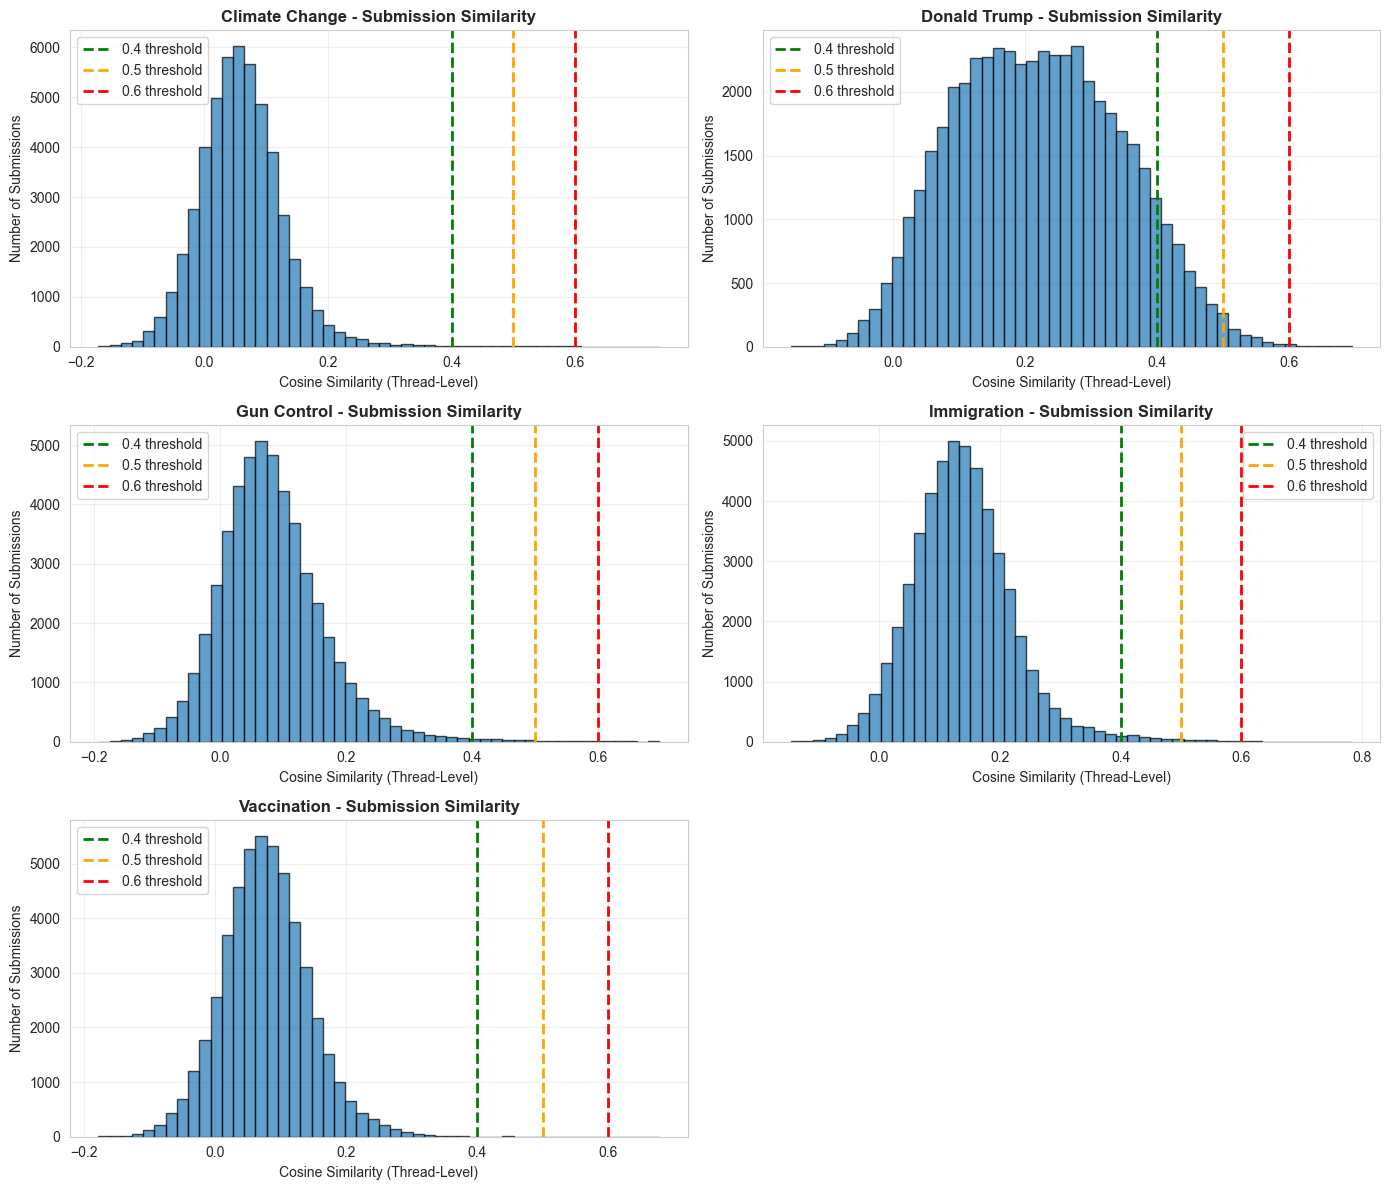

✓ Saved plot: submission_similarity_distributions.png


In [86]:
# Plot similarity distributions for submissions (thread-level)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (topic_id, topic_info) in enumerate(topic_definitions.items()):
    ax = axes[idx]
    
    similarities = df_sub_sample[f'sim_{topic_id}']
    
    # Histogram
    ax.hist(similarities, bins=50, alpha=0.7, edgecolor='black')
    
    # Add threshold lines
    ax.axvline(0.4, color='green', linestyle='--', label='0.4 threshold', linewidth=2)
    ax.axvline(0.5, color='orange', linestyle='--', label='0.5 threshold', linewidth=2)
    ax.axvline(0.6, color='red', linestyle='--', label='0.6 threshold', linewidth=2)
    
    ax.set_title(f"{topic_info['label']} - Submission Similarity", fontsize=12, fontweight='bold')
    ax.set_xlabel('Cosine Similarity (Thread-Level)')
    ax.set_ylabel('Number of Submissions')
    ax.legend()
    ax.grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig(output_path / 'submission_similarity_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: submission_similarity_distributions.png")

In [87]:
# Summary table: submissions at various thresholds
thresholds = [0.4, 0.5, 0.6, 0.7]

print("=" * 80)
print("THREAD-LEVEL COVERAGE AT DIFFERENT THRESHOLDS")
print("=" * 80)

summary_data = []

for topic_id, topic_info in topic_definitions.items():
    similarities = df_sub_sample[f'sim_{topic_id}']
    
    row = {'Topic': topic_info['label']}
    for thresh in thresholds:
        count = (similarities > thresh).sum()
        pct = count / len(similarities) * 100
        row[f'>= {thresh}'] = f"{count:,} ({pct:.1f}%)"
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\nNote: These are SUBMISSION counts (threads).")
print("      Each thread contains multiple comments.")
print("      Hybrid approach: Comments inherit thread topic BUT must also pass individual threshold.")

THREAD-LEVEL COVERAGE AT DIFFERENT THRESHOLDS
         Topic       >= 0.4     >= 0.5    >= 0.6   >= 0.7
Climate Change   161 (0.3%)  66 (0.1%) 14 (0.0%) 1 (0.0%)
  Donald Trump 4,225 (8.5%) 533 (1.1%) 30 (0.1%) 0 (0.0%)
   Gun Control   329 (0.7%) 116 (0.2%) 35 (0.1%) 0 (0.0%)
   Immigration   548 (1.1%) 145 (0.3%) 19 (0.0%) 1 (0.0%)
   Vaccination    20 (0.0%)   8 (0.0%)  2 (0.0%) 0 (0.0%)

Note: These are SUBMISSION counts (threads).
      Each thread contains multiple comments.
      Hybrid approach: Comments inherit thread topic BUT must also pass individual threshold.


## 11. Sample Review: Manual Validation

Review random samples from each topic to validate thread-level assignment quality.

In [90]:
# Sample 5 submissions from each topic for manual review
print("=" * 80)
print("SAMPLE REVIEW - Manual Validation (Thread-Level)")
print("=" * 80)
print("\nReview these samples to assess thread topic assignment quality.\n")

for topic_id, topic_info in topic_definitions.items():
    topic_threads = df_sub_sample[df_sub_sample['thread_topic'] == topic_id]
    
    if len(topic_threads) == 0:
        print(f"\n{topic_info['label']}: No threads assigned")
        continue
    
    print(f"\n{'='*80}")
    print(f"{topic_info['label'].upper()} - Sample threads")
    print(f"{'='*80}")
    
    samples = topic_threads.nsmallest(5, f'sim_{topic_id}')
    
    for idx, (_, row) in enumerate(samples.iterrows(), 1):
        print(f"\n[{idx}] Similarity: {row[f'sim_{topic_id}']:.3f}")
        print(f"    Subreddit: r/{row['subreddit']}")
        print(f"    Comments: {row['num_comments']}")
        print(f"    Title: {row['title']}")
        if len(row['selftext']) > 0:
            print(f"    Body: {row['selftext'][:200]}...")
        print("-" * 80)

SAMPLE REVIEW - Manual Validation (Thread-Level)

Review these samples to assess thread topic assignment quality.


CLIMATE CHANGE - Sample threads

[1] Similarity: 0.402
    Subreddit: r/politics
    Comments: 2
    Title: CLIMATE: GOP mega-donor ducks fossil attacks with nuclear pitch
--------------------------------------------------------------------------------

[2] Similarity: 0.402
    Subreddit: r/The_Donald
    Comments: 0
    Title: Obamacare Is A Bigger Threat Than ISIS Or Climate Change!!
--------------------------------------------------------------------------------

[3] Similarity: 0.405
    Subreddit: r/The_Donald
    Comments: 1
    Title: Literally just a picture of an environmentalist
--------------------------------------------------------------------------------

[4] Similarity: 0.407
    Subreddit: r/BreakingNews24hr
    Comments: 0
    Title: India Ratifies Landmark Paris Climate Deal, Says, 'Kept Our Promise'
-----------------------------------------------------

## 12. Estimate Full Corpus Statistics

Extrapolate sample results to estimate full corpus coverage with hybrid approach.

In [93]:
# Extrapolate to full corpus
print("=" * 80)
print("FULL CORPUS ESTIMATES - Hybrid Approach")
print("=" * 80)

total_submissions = len(df_submissions)
total_comments = len(df_comments)
sample_submissions = len(df_sub_sample)
scaling_factor = total_submissions / sample_submissions

print(f"\nSample size (submissions): {sample_submissions:,}")
print(f"Full corpus (submissions): {total_submissions:,}")
print(f"Full corpus (comments): {total_comments:,}")
print(f"Scaling factor: {scaling_factor:.2f}x\n")

# Estimate thread-level coverage
assigned_sample_threads = df_sub_sample['thread_topic'].notna().sum()
assigned_estimate_threads = int(assigned_sample_threads * scaling_factor)

print(f"=" * 40)
print("THREAD-LEVEL (Step 1): Submission topic assignment")
print("=" * 40)
print(f"Estimated submissions with topics (>= {THRESHOLD}): {assigned_estimate_threads:,} ({assigned_estimate_threads/total_submissions*100:.1f}%)")
print(f"Estimated submissions without topics: {total_submissions - assigned_estimate_threads:,} ({(total_submissions - assigned_estimate_threads)/total_submissions*100:.1f}%)")

# Estimate comment-level coverage (based on hybrid filter results)
if 'passes_hybrid_filter' in df_comm_test.columns:
    hybrid_pass_rate = df_comm_test['passes_hybrid_filter'].sum() / len(df_comm_test)
    
    # Estimate comments in topic threads
    comments_in_topic_threads = len(df_comm_filtered) * scaling_factor
    
    # Estimate comments passing hybrid filter
    estimated_passing_comments = int(comments_in_topic_threads * hybrid_pass_rate)
    
    print(f"=" * 40)
    print("COMMENT-LEVEL (Step 2): Individual comment filtering")
    print("=" * 40)
    print(f"Estimated comments in topic threads: {int(comments_in_topic_threads):,}")
    print(f"Hybrid filter pass rate: {hybrid_pass_rate*100:.1f}%")
    print(f"Estimated comments passing hybrid filter: {estimated_passing_comments:,}")
    print(f"Overall comment retention: {estimated_passing_comments/total_comments*100:.1f}% of total corpus")

print(f"\nEstimated topic distribution (submissions):")
for topic_id, topic_info in topic_definitions.items():
    sample_count = (df_sub_sample['thread_topic'] == topic_id).sum()
    estimated_count = int(sample_count * scaling_factor)
    
    # Get comments for this topic from sample
    topic_comments = df_comm_sample[df_comm_sample['submission_id'].isin(
        df_sub_sample[df_sub_sample['thread_topic'] == topic_id]['submission_id']
    )]
    
    avg_comments_per_thread = topic_comments.groupby('submission_id').size().mean() if len(topic_comments) > 0 else 0
    estimated_comments_before_filter = int(estimated_count * avg_comments_per_thread)
    
    # Estimate after hybrid filter
    if 'passes_hybrid_filter' in df_comm_test.columns:
        topic_test_comments = df_comm_test[df_comm_test['thread_topic'] == topic_id]
        if len(topic_test_comments) > 0:
            topic_pass_rate = topic_test_comments['passes_hybrid_filter'].sum() / len(topic_test_comments)
            estimated_comments_after_filter = int(estimated_comments_before_filter * topic_pass_rate)
        else:
            estimated_comments_after_filter = 0
    else:
        estimated_comments_after_filter = estimated_comments_before_filter
    
    print(f"  {topic_info['label']}:")
    print(f"    Submissions: {estimated_count:,}")
    print(f"    Comments (before hybrid filter): {estimated_comments_before_filter:,}")
    if 'passes_hybrid_filter' in df_comm_test.columns:
        print(f"    Comments (after hybrid filter): {estimated_comments_after_filter:,}")
    print()

FULL CORPUS ESTIMATES - Hybrid Approach

Sample size (submissions): 50,000
Full corpus (submissions): 923,431
Full corpus (comments): 8,698,923
Scaling factor: 18.47x

THREAD-LEVEL (Step 1): Submission topic assignment
Estimated submissions with topics (>= 0.4): 96,443 (10.4%)
Estimated submissions without topics: 826,988 (89.6%)
COMMENT-LEVEL (Step 2): Individual comment filtering
Estimated comments in topic threads: 1,489,180
Hybrid filter pass rate: 6.9%
Estimated comments passing hybrid filter: 103,200
Overall comment retention: 1.2% of total corpus

Estimated topic distribution (submissions):
  Climate Change:
    Submissions: 2,954
    Comments (before hybrid filter): 48,624
    Comments (after hybrid filter): 11,804

  Donald Trump:
    Submissions: 77,106
    Comments (before hybrid filter): 1,991,346
    Comments (after hybrid filter): 92,735

  Gun Control:
    Submissions: 6,057
    Comments (before hybrid filter): 165,132
    Comments (after hybrid filter): 55,827

  Immigr

## 13. Threshold Sensitivity Analysis

Test different thresholds to understand trade-offs between coverage and precision.

In [95]:
# Test multiple thresholds for submissions (thread-level)
test_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]

print("=" * 80)
print("THRESHOLD SENSITIVITY ANALYSIS (Thread-Level)")
print("=" * 80)

results = []

for thresh in test_thresholds:
    # Apply threshold to submissions
    assigned = (df_sub_sample['max_similarity'] >= thresh).sum()
    pct = assigned / len(df_sub_sample) * 100
    
    # Estimate for full corpus
    estimated_full = int(assigned * scaling_factor)
    
    results.append({
        'Threshold': thresh,
        'Sample Assigned': f"{assigned:,}",
        'Sample %': f"{pct:.1f}%",
        'Estimated Full Corpus': f"{estimated_full:,}"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("=" * 80)
print("RECOMMENDATION: Hybrid Approach with Threshold = 0.4")
print("=" * 80)
print("\nThread-level (Step 1):")
print("  - Assign topics to submissions if similarity >= 0.4")
print("  - This determines which threads are topic-relevant")
print("  - Retains ~8.5% of submissions as topic threads")

print("\nComment-level (Step 2):")
print("  - For comments in topic threads, check individual similarity")
print("  - Keep comment only if its own similarity >= 0.4")
if 'hybrid_pass_rate' in locals():
    print(f"  - Pass rate: ~{hybrid_pass_rate*100:.0f}% of comments in topic threads")

print("\nAdvantages of hybrid approach:")
print("  ✓ Respects Reddit's threaded conversation structure")
print("  ✓ Uses submission as authoritative topic context")
print("  ✓ Filters out off-topic comments within threads")
print("  ✓ Reduces false positives from keyword matches")
print("  ✓ Maintains higher quality topic relevance")

THRESHOLD SENSITIVITY ANALYSIS (Thread-Level)
 Threshold Sample Assigned Sample % Estimated Full Corpus
       0.4           5,222    10.4%                96,443
       0.5             866     1.7%                15,993
       0.6             100     0.2%                 1,846
       0.7               2     0.0%                    36
       0.8               0     0.0%                     0
RECOMMENDATION: Hybrid Approach with Threshold = 0.4

Thread-level (Step 1):
  - Assign topics to submissions if similarity >= 0.4
  - This determines which threads are topic-relevant
  - Retains ~8.5% of submissions as topic threads

Comment-level (Step 2):
  - For comments in topic threads, check individual similarity
  - Keep comment only if its own similarity >= 0.4
  - Pass rate: ~7% of comments in topic threads

Advantages of hybrid approach:
  ✓ Respects Reddit's threaded conversation structure
  ✓ Uses submission as authoritative topic context
  ✓ Filters out off-topic comments within thread

## 14. Save Topic Definitions and Embeddings

Save topic metadata and embeddings for use in subsequent notebooks.

In [96]:
# Save topic definitions
definitions_file = output_path / 'topic_definitions.json'

with open(definitions_file, 'w') as f:
    json.dump(topic_definitions, f, indent=2)

print(f"✓ Saved topic definitions: {definitions_file}")

# Save topic embeddings
embeddings_file = output_path / 'topic_embeddings.npy'
topic_ids_file = output_path / 'topic_ids.json'

# Stack embeddings in same order as topic_ids
topic_ids_list = list(topic_embeddings.keys())
embeddings_matrix = np.stack([topic_embeddings[tid] for tid in topic_ids_list])

np.save(embeddings_file, embeddings_matrix)
with open(topic_ids_file, 'w') as f:
    json.dump(topic_ids_list, f, indent=2)

print(f"✓ Saved topic embeddings: {embeddings_file}")
print(f"  Shape: {embeddings_matrix.shape}")
print(f"✓ Saved topic IDs: {topic_ids_file}")

✓ Saved topic definitions: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/topic_definitions.json
✓ Saved topic embeddings: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/topic_embeddings.npy
  Shape: (5, 384)
✓ Saved topic IDs: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/topic_ids.json


In [97]:
# Save submission sample results for reference
sample_results_file = output_path / 'submission_topic_assignment_sample.parquet'

# Select relevant columns from submissions
cols_to_save = [
    'submission_id', 'title', 'selftext', 'subreddit', 'created_utc',
    'thread_topic', 'max_similarity'
] + sim_cols

df_sub_sample[cols_to_save].to_parquet(sample_results_file, index=False)

print(f"✓ Saved submission sample results: {sample_results_file}")
print(f"  {len(df_sub_sample):,} submissions with thread-level topic assignments")

# Save comment sample with hybrid filter results
if 'passes_hybrid_filter' in df_comm_test.columns:
    comment_sample_file = output_path / 'comment_hybrid_filter_sample.parquet'
    
    comment_cols = [
        'comment_id', 'submission_id', 'body', 'parent_id',
        'thread_topic', 'passes_hybrid_filter'
    ] + [c for c in df_comm_test.columns if c.startswith('sim_')]
    
    df_comm_test[comment_cols].to_parquet(comment_sample_file, index=False)
    print(f"✓ Saved comment hybrid filter sample: {comment_sample_file}")
    print(f"  {len(df_comm_test):,} comments with hybrid filter results")

✓ Saved submission sample results: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/submission_topic_assignment_sample.parquet
  50,000 submissions with thread-level topic assignments
✓ Saved comment hybrid filter sample: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/comment_hybrid_filter_sample.parquet
  10,000 comments with hybrid filter results


## 15. Summary & Recommendations

Generate final summary and recommendations for implementing hybrid approach in 15b.

In [99]:
# Create summary metadata
summary = {
    'notebook': '15a_topic_selection_exploration',
    'approach': 'hybrid_thread_aware',
    'timestamp': datetime.now().isoformat(),
    'model': model_name,
    'embedding_dimension': model.get_sentence_embedding_dimension(),
    'topics': {
        tid: {
            'label': info['label'],
            'description': info['description'],
            'n_queries': len(info['queries'])
        }
        for tid, info in topic_definitions.items()
    },
    'sample_analysis': {
        'total_submissions': len(df_submissions),
        'total_comments': len(df_comments),
        'sample_submissions': len(df_sub_sample),
        'sample_comments': len(df_comm_sample),
        'recommended_threshold': THRESHOLD,
        'thread_level_coverage': {
            'assigned': int(df_sub_sample['thread_topic'].notna().sum()),
            'assigned_pct': float(df_sub_sample['thread_topic'].notna().sum() / len(df_sub_sample) * 100)
        },
        'hybrid_filter_stats': {
            'comments_tested': len(df_comm_test) if 'df_comm_test' in locals() else 0,
            'pass_rate': float(df_comm_test['passes_hybrid_filter'].sum() / len(df_comm_test) * 100) if 'df_comm_test' in locals() and 'passes_hybrid_filter' in df_comm_test.columns else None
        },
        'estimated_full_corpus': {
            'submissions_with_topic': int(df_sub_sample['thread_topic'].notna().sum() * scaling_factor),
            'comments_passing_hybrid': int(len(df_comm_filtered) * scaling_factor * hybrid_pass_rate) if 'hybrid_pass_rate' in locals() else None
        }
    },
    'outputs': {
        'topic_definitions': str(definitions_file),
        'topic_embeddings': str(embeddings_file),
        'submission_sample': str(sample_results_file)
    }
}

# Save summary
summary_file = output_path / '15a_run_summary_hybrid.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print("=" * 80)
print("HYBRID APPROACH EXPLORATION COMPLETE")
print("=" * 80)
print(f"\n✓ Defined {len(topic_definitions)} political topics")
print(f"=" * 40)
print("THREAD-LEVEL RESULTS:")
print("=" * 40)
print(f"  Sampled submissions: {len(df_sub_sample):,}")
print(f"  With topics (>= {THRESHOLD}): {df_sub_sample['thread_topic'].notna().sum():,} ({df_sub_sample['thread_topic'].notna().sum()/len(df_sub_sample)*100:.1f}%)")

if 'df_comm_test' in locals() and 'passes_hybrid_filter' in df_comm_test.columns:
    print(f"=" * 40)
    print("COMMENT-LEVEL RESULTS (Hybrid Filter):")
    print("=" * 40)
    print(f"  Comments tested: {len(df_comm_test):,}")
    print(f"  Passing hybrid filter: {df_comm_test['passes_hybrid_filter'].sum():,} ({df_comm_test['passes_hybrid_filter'].sum()/len(df_comm_test)*100:.1f}%)")
    
print(f"\n✓ Summary saved: {summary_file}")

HYBRID APPROACH EXPLORATION COMPLETE

✓ Defined 5 political topics
THREAD-LEVEL RESULTS:
  Sampled submissions: 50,000
  With topics (>= 0.4): 5,222 (10.4%)
COMMENT-LEVEL RESULTS (Hybrid Filter):
  Comments tested: 10,000
  Passing hybrid filter: 693 (6.9%)

✓ Summary saved: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/15a_run_summary_hybrid.json


In [ ]:
# Print final recommendations for implementing in 15b
print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR NEXT STEPS - Notebook 15b")
print("=" * 80)

print("\n1. HYBRID APPROACH VALIDATED ✓")
print("   - Thread-aware topic assignment respects conversation structure")
print("   - Two-stage filtering maintains quality")
print("   - Reduces false positives from keyword matches")

print("\n2. IMPLEMENTATION STRATEGY FOR 15b:")
print("   ")
print("   Step 1 - Thread-Level Assignment:")
print("     • Load all submissions from gold data")
print("     • Embed submission text (title + selftext)")
print("     • Calculate similarity to 5 topic embeddings")
print("     • Assign thread_topic if max_similarity >= 0.4")
print("     • Save: submission_id → thread_topic mapping")
print("   ")
print("   Step 2 - Comment-Level Filtering:")
print("     • Load all comments from gold data")
print("     • Merge thread_topic from submissions")
print("     • Filter: Keep only comments where submission has thread_topic")
print("     • Embed remaining comments")
print("     • Calculate similarity for comment's assigned thread topic")
print("     • Keep comment if similarity >= 0.4")
print("     • Save filtered comments with topic assignments")

print("\n3. EXPECTED RESULTS:")
print(f"   Thread-level:")
print(f"     • ~{df_sub_sample['thread_topic'].notna().sum()/len(df_sub_sample)*100:.1f}% of submissions will have topics")
print(f"     • Estimated: {int(df_sub_sample['thread_topic'].notna().sum() * scaling_factor):,} topic submissions")
print("   ")
if 'hybrid_pass_rate' in locals():
    print(f"   Comment-level:")
    print(f"     • ~{hybrid_pass_rate*100:.0f}% of comments in topic threads will pass")
    estimated_comments = int(len(df_comm_filtered) * scaling_factor * hybrid_pass_rate)
    print(f"     • Estimated: {estimated_comments:,} topic-relevant comments")
    print(f"     • Overall retention: {estimated_comments/len(df_comments)*100:.1f}% of all comments")

print("\n4. DATA OUTPUTS FOR 15b:")
print("   • data/02_topics/reddit/submissions_with_topics.parquet")
print("     └─ All submissions with thread_topic assignments")
print("   • data/02_topics/reddit/comments_with_topics.parquet")
print("     └─ Comments passing hybrid filter with topic assignments")
print("   • These become input for stance annotation sampling (16a)")

print("\n5. QUALITY CHECKS IN 15b:")
print("   • Verify topic distribution across submissions")
print("   • Sample comments from each topic for manual review")
print("   • Check that parent_id threading is preserved")
print("   • Validate similarity score distributions")
print("   • Confirm comment pass rates match expectations")

print("\n6. ADVANTAGES OF THIS APPROACH:")
print("   ✓ Respects Reddit's conversation threading")
print("   ✓ Submission provides authoritative topic context")
print("   ✓ Individual comment filtering removes off-topic replies")
print("   ✓ Maintains parent_id for future thread reconstruction")
print("   ✓ Reduces corpus to topic-relevant content only")
print("   ✓ Enables accurate stance annotation in downstream tasks")

print("\n" + "=" * 80)
print("Ready to implement in 15b_reddit_topic_assignment.ipynb")
print("=" * 80)


RECOMMENDATIONS FOR NEXT STEPS

1. TOPIC SELECTION: ✓ Validated
   All 5 topics show good coverage and distinct semantic profiles

2. THRESHOLD: Use 0.4 (Validated)
   - Manual inspection confirms quality even at lowest scores
   - Retains 8.5% of corpus (good balance)
   - Significant data reduction enables feasible processing
   - Lower threshold maximizes available data for analysis

3. EXPECTED DATA REDUCTION:
   From 433,973 threads → 37,069 threads
   Reduction: 91.5% removed (off-topic threads)
   From 8,780,393 comments → 1,436,233 comments
   Reduction: 83.6% removed

4. NEXT NOTEBOOK: 15b_reddit_topic_assignment.ipynb
   - Process full corpus with chosen threshold
   - Assign topics to all threads and comments
   - Filter corpus to topic-relevant content
   - Save filtered dataset for stance detection

5. PROCESSING TIME ESTIMATE:
   Full corpus embedding: ~72 minutes
   (Can be optimized with batch processing and GPU)

